In [1]:
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.units as u
from photutils.centroids import centroid_com
from photutils import CircularAperture, CircularAnnulus,aperture_photometry
from photutils.detection import DAOStarFinder
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from photutils.utils import calc_total_error
from astropy.stats import sigma_clip
from astropy.table import Table
import pandas as pd
import uncertainties
from matplotlib.colors import LogNorm
from scipy.interpolate import UnivariateSpline
from astropy.stats import sigma_clipped_stats
from photutils.centroids import centroid_sources
import astroalign as aa
from astropy.wcs import WCS

In [2]:
dir = 'C:/Users/Tim/Downloads/535 Data/'

In [3]:
field_table = pd.read_csv(dir+'standards/field_table.csv')

RA = field_table['RA (J2000)']
DEC = field_table['Dec (J2000)']
Gmag = field_table['V']
Rmag = field_table['V']-field_table['V-R']
Imag = Rmag-field_table['R-I']

c = SkyCoord(RA,DEC, unit=(u.hourangle, u.deg))

field_table

,Star,RA (J2000),Dec (J2000),V,B-V,U-B,V-R,R-I,X,Y
0,110 360,18:42:40,+00:09:10,14.618,1.197,0.539,0.715,0.717,1417.8908,1579.6706
1,110 361,18:42:45,+00:08:04,12.425,0.632,0.035,0.361,0.348,1567.4297,1428.6083
2,110 362,18:42:48,+00:06:26,15.693,1.333,3.919,0.918,0.885,1674.8174,1208.3935
3,110 L1,18:42:50,+00:07:10,16.252,1.752,2.953,1.066,0.992,1739.9907,1308.9297
4,110 266,18:42:49,+00:05:06,12.018,0.889,0.411,0.538,0.577,1687.8623,1027.8024
5,110 364,18:42:52,+00:07:54,13.615,1.133,1.095,0.697,0.585,1829.3971,1402.5939
6,110 365,18:42:57,+00:07:20,13.470,2.261,1.895,1.360,1.270,1984.4428,1328.4724


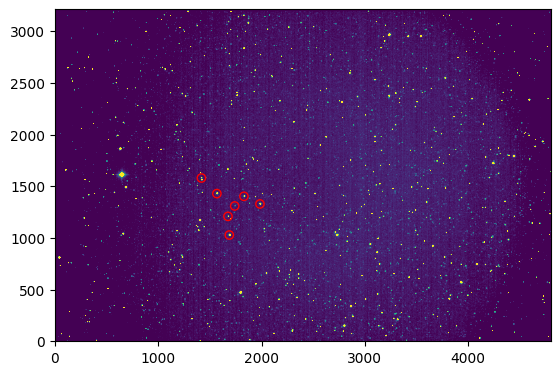

In [4]:
filter='SR'

files = glob.glob(dir+'standards/*median*{}*.fits'.format(filter))

image = fits.open(files[0])
data = image[0].data
data = np.float64(data)
header = image[0].header
wcs = WCS(header)

xwcs, ywcs = wcs.all_world2pix(c.ra.deg, c.dec.deg,1)

x,y = field_table['X'],field_table['Y'] #wcs positions were inaccurate so use those to find real positions by-eye
plt.imshow(data,vmin=np.median(data),vmax=np.median(data)+100,origin='lower')
plt.scatter(x,y,edgecolor='red',facecolor='None')


# Aperture Photometry

In [19]:
gain = 0.8

if filter=='SR':
    M = Rmag
if filter=='SG':
    M = Gmag
if filter=='SI':
    M = Imag
# Get the x and y coordinates
source_positions = np.column_stack((x, y))
median_FWHM = 4.5
# Make the apertures
aperture = CircularAperture(source_positions, r=2*median_FWHM)
annulus = CircularAnnulus(source_positions, r_in=2*median_FWHM+5, r_out=2*median_FWHM+10)

# Store the apertures as a list
phot_aper = [aperture, annulus]

# Sigma clip the data
filtered_data = sigma_clip(data, sigma=3., copy=False)

# Mask the data
bkg_values_nan = filtered_data.filled(fill_value=np.nan)

# Calculate the error on the background
bkg_error = np.sqrt(bkg_values_nan)

# Replace NaNs with median
bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)

# Calculate the total error
unc_data = calc_total_error(data, bkg_error,effective_gain=gain) 

# Make the photometry table
phot_table = aperture_photometry(data, phot_aper, error=unc_data)

# Calculate the background
bkg_mean = phot_table['aperture_sum_1'] / annulus.area

# Calculate the background counts sum
bkg_ap_sum = bkg_mean * aperture.area

# Subtract the backgroun
final_sum = phot_table['aperture_sum_0']-bkg_ap_sum

# Store the background subtracted counts
phot_table['bg_subtracted_counts'] = final_sum

# Calculate the error on the background
bkg_mean_err = phot_table['aperture_sum_err_1'] / annulus.area

# Calculate the background counts sum error
bkg_sum_err = bkg_mean_err * aperture.area

# Calculate the background subtracted counts error
phot_table['bg_sub_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2)) 

# Calculate the instrumental magnitude
phot_table['Instr_Mag'] = -2.5*np.log10(phot_table['bg_subtracted_counts']/header['EXPTIME'])

# Calculate the instrumental magnitude error
phot_table['Instr_Mag_err'] = np.abs((-5/(2*np.log(10)))*(header['EXPTIME']
                                                          /phot_table['bg_subtracted_counts'])*phot_table['bg_sub_cts_err'])

# Calculate Zeropoint for each Star
phot_table['zeropoint'] = M-phot_table['Instr_Mag']

phot_table['counts_sec'] = phot_table['bg_subtracted_counts']/header['EXPTIME']

In [20]:
# Display the table
phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,bg_subtracted_counts,bg_sub_cts_err,Instr_Mag,Instr_Mag_err,zeropoint,counts_sec
,pix,pix,,,,,,,,,,
int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1417.8908,1579.6706,50319.78708537901,297.2558361093484,48615.80987039708,330.28834821687076,26453.844058093164,338.60141055940534,-7.363418835973505,0.41691310678991444,21.266418835973504,881.7948019364388
2,1567.4297,1428.6083,186437.2150998288,508.02237350736823,49502.153547298934,333.05707470184,162136.15790388206,533.6845752399314,-9.331896556815408,0.1072137158207109,21.39589655681541,5404.538596796069
3,1674.8174,1208.3935,41338.36702464921,277.8512656178854,49584.84105254989,333.3761632649684,16996.717780670173,322.4671562470211,-6.883109521445341,0.6179680175327048,21.65810952144534,566.5572593556724
4,1739.9907,1308.9297,32043.510435096374,255.54138310451174,49239.070991763845,331.8076309546311,7871.602857321395,303.04075278162,-6.047354799947343,1.2539592867269906,21.233354799947342,262.3867619107132
5,1687.8623,1027.8024,282779.88753414154,614.2107551072168,50984.17915728798,338.16323901111934,257751.29049329108,636.2494096504487,-9.835198984100517,0.08040297505297561,21.31519898410052,8591.709683109702
6,1829.3971,1402.5939,93171.75016200307,376.9584243399087,49079.28593518924,331.7707318554286,69078.28252109198,410.63859080547314,-8.405550691342519,0.1936260582212198,21.32355069134252,2302.609417369733
7,1984.4428,1328.4724,137395.64783112815,443.9091301899024,50234.94889969856,335.21364912199437,112734.85473491249,473.4291088723058,-8.937342387095589,0.13678621179697736,21.04734238709559,3757.8284911637497


In [18]:
#compute zeropoint and transformation coefficient
A = np.array(M-phot_table['Instr_Mag'])
B = np.array(field_table['V-R'])

X = np.vstack((B, np.ones(len(B)))).T

t, C = np.linalg.lstsq(X, A, rcond=None)[0]

print("transformation coefficient t:", t)
print("Zeropoint:", C)

transformation coefficient t: -0.24180010328160031
Zeropoint: 21.515321622968237
